In [16]:
suppressMessages(library(ggplot2))
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(purrr))
suppressMessages(library(readr))
suppressMessages(library(patchwork))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(ggrepel))
suppressMessages(library(rhdf5))
suppressMessages(library(chromVARmotifs))
suppressMessages(library(ChIPseeker))
suppressMessages(library(TxDb.Hsapiens.UCSC.hg38.knownGene))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(GenomicRanges))
suppressMessages(library(writexl))
suppressMessages(library(anndata))
suppressMessages(library(reticulate))

In [2]:
set.seed(42)
addArchRThreads(threads = 64)

Setting default number of Parallel threads to 64.



In [3]:
proj <- loadArchRProject("./ArchRProject_Myeloid", showLogo = FALSE)

Successfully loaded ArchRProject!



In [4]:
rna_myeloid <- readRDS(file = "/data/hanxue/BCY_ATAC/scRNA_Myeloid.rds")

In [ ]:
rna_myeloid$`anno-Mye`

In [8]:
# 整合 scATAC-seq 和 scRNA-seq 数据
proj <- addGeneIntegrationMatrix(
  ArchRProj = proj,
  useMatrix = "GeneScoreMatrix",  # scATAC-seq 的基因评分矩阵
  matrixName = "GeneIntegrationMatrix",  # 输出矩阵名称
  reducedDims = "Harmony_Myeloid",  # scATAC-seq 的降维结果
  seRNA = rna_myeloid,  # scRNA-seq 的 Seurat 对象
  addToArrow = FALSE,  # 将结果保存到 Arrow 文件
  groupRNA = "anno-Mye",  # scRNA-seq 中细胞类型的列名
  nameCell = "predictedCell",  # 存储匹配的 scRNA-seq 细胞 ID
  nameGroup = "predictedGroup",  # 存储预测的细胞类型
  nameScore = "predictedScore",  # 存储整合得分
  sampleCellsATAC = 10000,  # 采样 scATAC-seq 细胞数
  sampleCellsRNA = 10000,  # 采样 scRNA-seq 细胞数
  dimsToUse = 1:30,  # 使用的前 30 个降维维度
  force = TRUE  # 强制覆盖现有矩阵
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-581ae2d950eb4-Date-2025-04-24_Time-06-41-26.948532.log
If there is an issue, please report to github with logFile!

2025-04-24 06:41:27.14304 : Running Seurat's Integration Stuart* et al 2019, 0.003 mins elapsed.

2025-04-24 06:41:27.238421 : Checking ATAC Input, 0.005 mins elapsed.

2025-04-24 06:41:27.557378 : Checking RNA Input, 0.01 mins elapsed.

2025-04-24 06:41:34.090582 : Found 20181 overlapping gene names from gene scores and rna matrix!, 0.119 mins elapsed.

2025-04-24 06:41:34.093956 : Creating Integration Blocks, 0.119 mins elapsed.

2025-04-24 06:41:34.168957 : Prepping Interation Data, 0.12 mins elapsed.

subThreading Disabled since ArchRLocking is TRUE see `addArchRLocking`

Warning! Not all requested dimsToUse are available! The follow dims were not found in Harmony_Myeloid:
30
Unavailable dims will be automatically excluded...

2025-04-24 06:41:35.16002 : Computing Integration in 1 Integration Blocks!, 0 mins 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-581ae6249cb92-Date-2025-04-24_Time-06-48-53.739396.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-581ae6249cb92-Date-2025-04-24_Time-06-48-53.739396.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-581ae58ac82a4-Date-2025-04-24_Time-06-48-54.268125.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-581ae58ac82a4-Date-2025-04-24_Time-06-48-54.268125.log



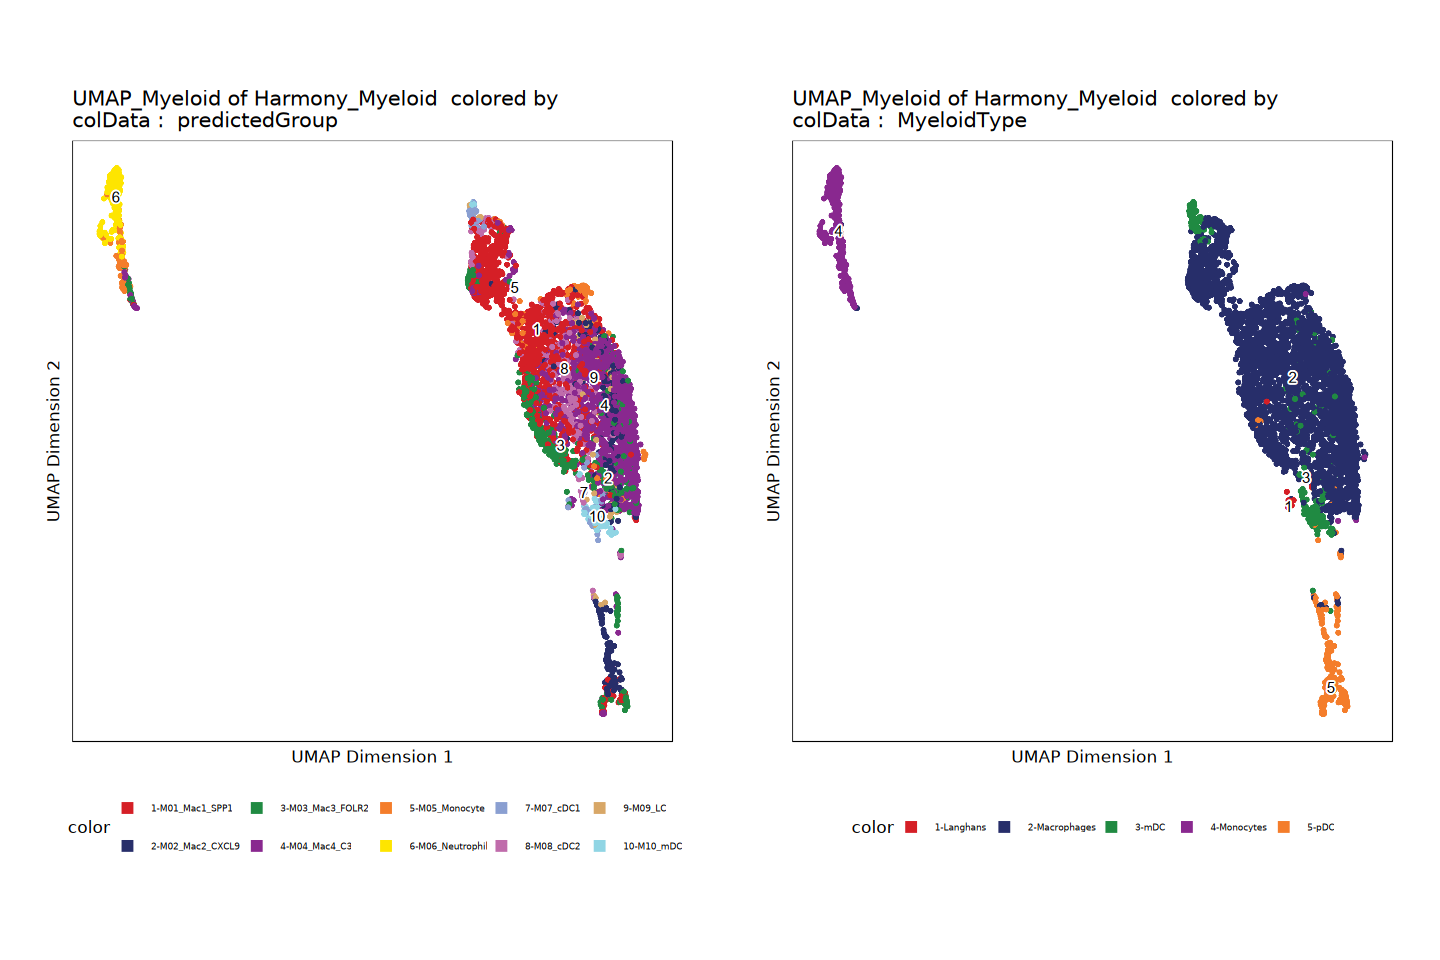

In [14]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
  ArchRProj = proj,
  colorBy = "cellColData",
  name = "predictedGroup",
  embedding = "UMAP_Myeloid",
  size = 1.5,
  labelsize = 6
)

p2 <- plotEmbedding(
  ArchRProj = proj,
  colorBy = "cellColData",
  name = "MyeloidType",
  embedding = "UMAP_Myeloid",
  size = 1.5,
  labelsize = 6
)
ggAlignPlots(p1, p2,type = 'h')

In [28]:
unique(proj$predictedGroup)

[1] "M09_LC"         "M03_Mac3_FOLR2" "M10_mDC"        "M04_Mac4_C3"   
 [5] "M01_Mac1_SPP1"  "M02_Mac2_CXCL9" "M08_cDC2"       "M07_cDC1"      
 [9] "M05_Monocyte"   "M06_Neutrophil"

In [30]:
# 把效应T筛选出来进行细分
MacroList <- c('M01_Mac1_SPP1', 'M02_Mac2_CXCL9', 'M03_Mac3_FOLR2', 'M04_Mac4_C3')
macro_cells <- getCellNames(ArchRProj = proj)[proj$predictedGroup %in% MacroList]
proj_sub <- proj[macro_cells,]

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!



In [31]:
proj_sub <- addHarmony(
    ArchRProj = proj_sub,
    reducedDims = "Harmony_Myeloid",
    name = "Harmony_Macro",
    groupBy = "Sample",
    force = TRUE
)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



In [32]:
proj_sub <- addUMAP(
    ArchRProj = proj_sub,
    reducedDims = "Harmony_Macro",
    name = "UMAP_Macro",
    nNeighbors = 45,   # 默认是 15，可以尝试 30 或更大
    minDist = 0.05,     # 默认是 0.1，可以尝试 0.05 或更小
    metric = "cosine",  # 可以尝试不同的距离度量，如 "euclidean", "manhattan"
    force = TRUE
)

07:23:51 UMAP embedding parameters a = 1.75 b = 0.8421



07:23:51 Read 3443 rows and found 29 numeric columns

07:23:51 Using Annoy for neighbor search, n_neighbors = 45

07:23:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:23:52 Writing NN index file to temp file /tmp/RtmpQaQ5iY/file581ae1e69ed32

07:23:52 Searching Annoy index using 48 threads, search_k = 4500

07:23:52 Annoy recall = 100%

07:23:53 Commencing smooth kNN distance calibration using 48 threads
 with target n_neighbors = 45

07:23:54 Initializing from normalized Laplacian + noise (using RSpectra)

07:23:54 Commencing optimization for 500 epochs, with 237088 positive edges

07:23:54 Using rng type: pcg

07:24:02 Optimization finished

07:24:02 Creating temp model dir /tmp/RtmpQaQ5iY/dir581ae765cb6a1

07:24:02 Creating dir /tmp/RtmpQaQ5iY/dir581ae765cb6a

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-581aefa793f0-Date-2025-04-24_Time-07-24-11.773504.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-581aefa793f0-Date-2025-04-24_Time-07-24-11.773504.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-581ae17a31c22-Date-2025-04-24_Time-07-24-12.199236.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-581ae17a31c22-Date-2025-04-24_Time-07-24-12.199236.log



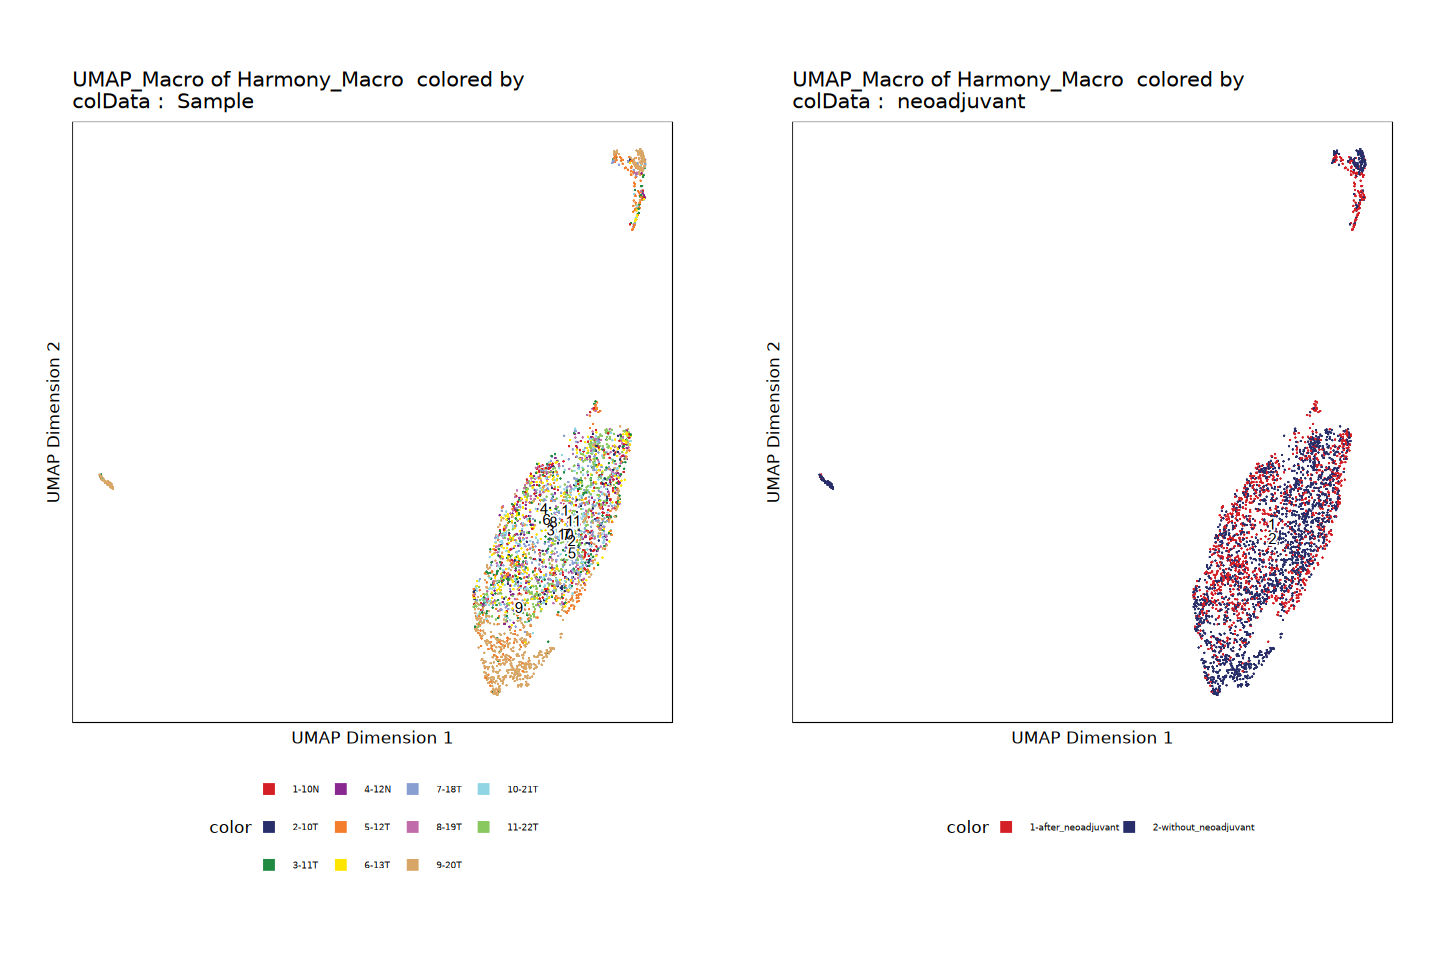

In [33]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
    ArchRProj = proj_sub, 
    colorBy = "cellColData", 
    name = "Sample", 
    embedding = "UMAP_Macro"
    )
p2 <- plotEmbedding(
    ArchRProj = proj_sub, 
    colorBy = "cellColData", 
    name = "neoadjuvant", 
    embedding = "UMAP_Macro"
    )
ggAlignPlots(p1, p2, type = "h")

In [34]:
proj_sub <- addClusters(proj_sub, name = "clusters_Macro", resolution = 1.0, force = TRUE)

ArchR logging to : ArchRLogs/ArchR-addClusters-581ae29260e9a-Date-2025-04-24_Time-07-24-31.42831.log
If there is an issue, please report to github with logFile!



Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2025-04-24 07:24:31.655178 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3443
Number of edges: 128347

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7701
Number of communities: 12
Elapsed time: 0 seconds


2025-04-24 07:24:35.509015 : Testing Outlier Clusters, 0.067 mins elapsed.

2025-04-24 07:24:35.514326 : Assigning Cluster Names to 12 Clusters, 0.067 mins elapsed.

2025-04-24 07:24:35.559667 : Finished addClusters, 0.068 mins elapsed.



ArchR logging to : ArchRLogs/ArchR-plotEmbedding-581ae4c92e20e-Date-2025-04-24_Time-07-25-20.056839.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-581ae4c92e20e-Date-2025-04-24_Time-07-25-20.056839.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-581ae1c9247ed-Date-2025-04-24_Time-07-25-20.613294.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-581ae1c9247ed-Date-2025-04-24_Time-07-25-20.613294.log



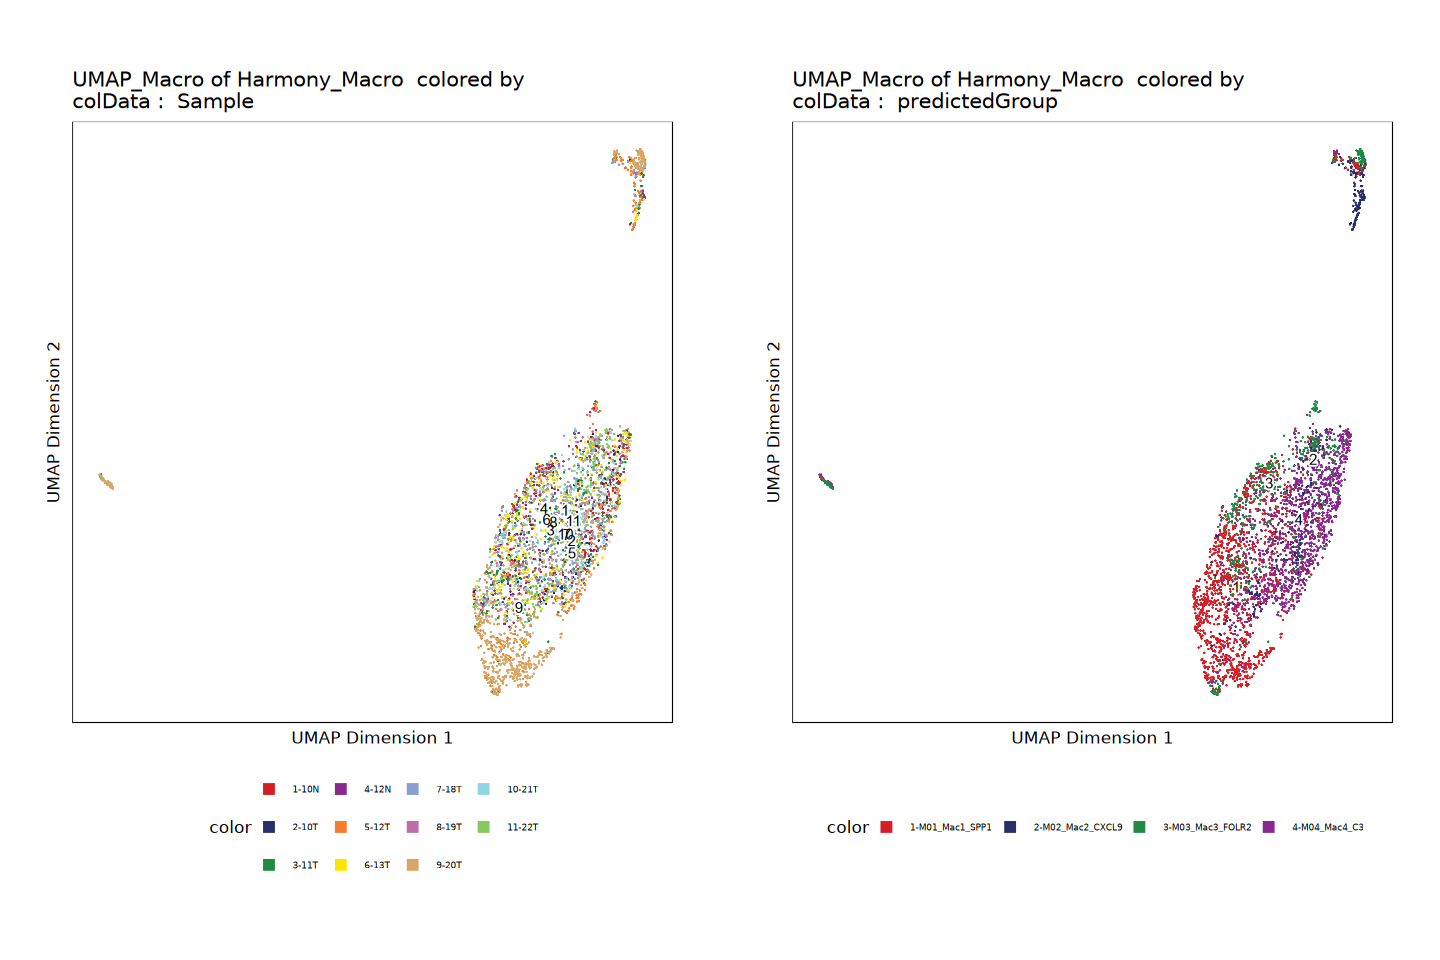

In [35]:
p1 <- plotEmbedding(
    ArchRProj = proj_sub, 
    colorBy = "cellColData", 
    name = "Sample", 
    embedding = "UMAP_Macro"
    )
p2 <- plotEmbedding(
    ArchRProj = proj_sub, 
    colorBy = "cellColData", 
    name = "predictedGroup", 
    embedding = "UMAP_Macro"
    )
ggAlignPlots(p1, p2, type = "h")

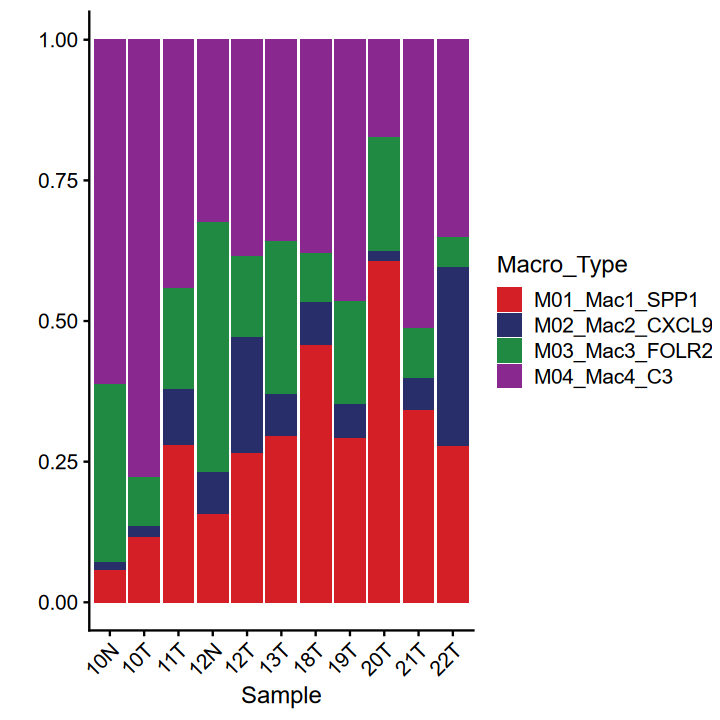

In [37]:
# 计算各样本中细胞类型的比例
sample_cell_type_distribution <- table(proj_sub$Sample, proj_sub$predictedGroup)
sample_cell_type_distribution <- prop.table(sample_cell_type_distribution, 1)

# 转换为数据框
df_sample <- as.data.frame(sample_cell_type_distribution)
df_sample$Var2 <- factor(df_sample$Var2, levels = MacroList)
cols <- ArchR::paletteDiscrete(df_sample$Var2)

# 创建堆叠图
p <- ggplot(df_sample, aes(x = Var1, y = Freq, fill = Var2)) +
  geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
  scale_fill_manual(values = cols) +
  theme_cowplot() +
  xlab("Sample") +
  ylab("") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(fill = "Macro_Type")

options(repr.plot.width = 6, repr.plot.height = 6)
# ggsave("/data/hanxue/BCY_ATAC/joint_output/Sample-CellType-Distribution.svg",plot = p, width = 6, height = 6, device = "svg")
p

In [15]:
# 保存
saveArchRProject(ArchRProj = proj, 
                 load = FALSE)
sessionInfo()

Saving ArchRProject...



R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/hanxue/miniconda3/envs/scseq/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] future_1.40.0               reticulate_1.42.0          
 [3] anndata_0.7.5.6             Signac_1.14.0              
 [5] Seurat_5.3.0                SeuratObject_